# Classification Analysis (with limited time interval) + supervised PCA

## Imports

In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from os.path import join as pjoin
from copy import deepcopy as dc
from tqdm.notebook import tqdm
import pickle
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

github_path = pjoin(os.environ['HOME'], 'Dropbox/git/A1ToneDiscrimination/')
sys.path.insert(0, github_path)
from utils.plot_functions import *
from utils.generic_utils import load_dfs, get_tasks

In [2]:
base_dir = pjoin(os.environ['HOME'], 'Documents/A1')
processed_dir = pjoin(base_dir, 'python_processed')

nb_std = 1
h_load_file = pjoin(processed_dir, "organized_nb_std={:d}.h5".format(nb_std))

run_dir = pjoin(base_dir, 'results/svm/v1_l1_full')

## Part 1) Performance comparison

### Box plots

Reminder about onset timepoints:

- stim onset: t = 30 (i.e. 1s)
- licking onset: t = 45 (i.e. = 1.5s)
- stim end: t = 60 (i.e. 2s)

Here I compare 3 SVM + L1 fits:

1. Best time point is allowed in range 30 to 135 (i.e. 1s:end)
2. Best time point is allowed in range 30 to 60 (i.e. 1s:2s)
3. Best time point is allowed in range 30 to 45 (i.e. 1s:1.5s)

#### Max performance obtained: ~0.82 (much better than chance: 0)

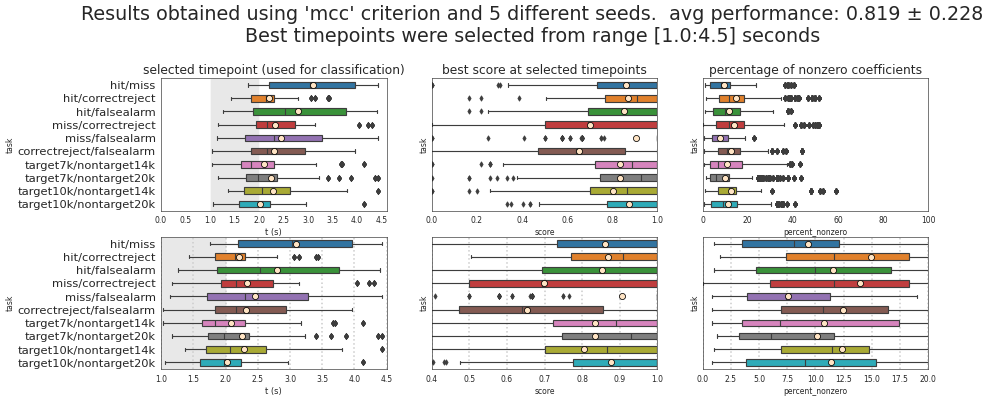

In [4]:
start_time = 30
end_time = 135
dir_name = next(filter(lambda x: "{:d}:{:d}".format(start_time, end_time) in x, os.listdir(run_dir)), None)
load_dir = pjoin(run_dir, dir_name)
df_all = load_dfs(load_dir)

_ = mk_boxplots(
    df_all=df_all,
    criterion='mcc',
    start_time=start_time,
    end_time=end_time,
    figsize=(18, 7),
    dpi=55,
)

#### Limiting to 1:2 seconds performance drops: ~0.74

This period is limited to the listening period, and allowig 0.5 s for the temporal delay of calcium indicators

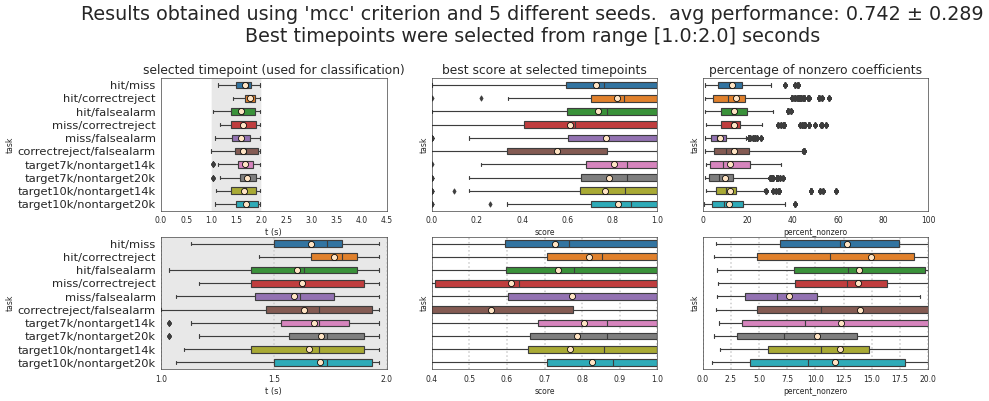

In [5]:
start_time = 30
end_time = 60
dir_name = next(filter(lambda x: "{:d}:{:d}".format(start_time, end_time) in x, os.listdir(run_dir)), None)
load_dir = pjoin(run_dir, dir_name)
df_all = load_dfs(load_dir)

_ = mk_boxplots(
    df_all=df_all,
    criterion='mcc',
    start_time=start_time,
    end_time=end_time,
    figsize=(18, 7),
    dpi=53,
)

#### Limiting to 1:1.5 seconds performance drops more: ~0.63 (still significantly better than chance)

This period is strictly the listening period (without allowig for the temporal delay of calcium indicators)

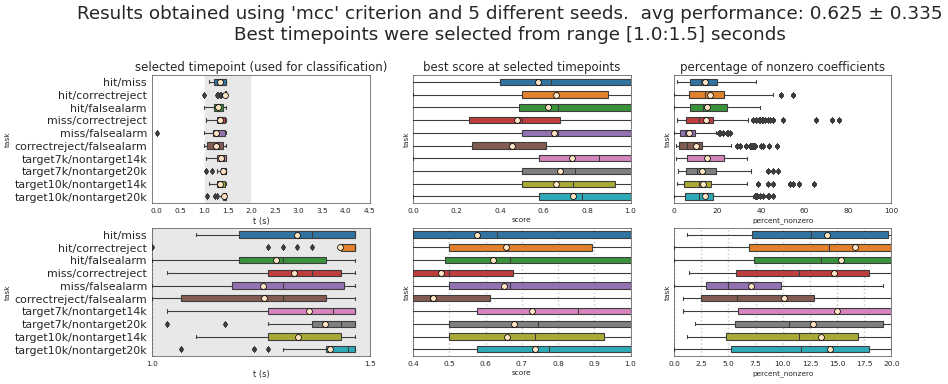

In [4]:
start_time = 30
end_time = 45
dir_name = next(filter(lambda x: "{:d}:{:d}".format(start_time, end_time) in x, os.listdir(run_dir)), None)
load_dir = pjoin(run_dir, dir_name)
df_all = load_dfs(load_dir)

_ = mk_boxplots(
    df_all=df_all,
    criterion='mcc',
    start_time=start_time,
    end_time=end_time,
    figsize=(18, 7),
    dpi=53,
)

## Part 2) Supervised PCA analysis

Here my goal was to apply supervised PCA to the data and infer something about its dimensionality. Unfortunately the analysis cannot be carried out as it was in the NeuroImage paper.  The main reason is that:

- sometiems number of samples here are too few for a task (can be as few as 3) and the number of PC dimensions is limited to $min(num_{features}, num_{samples})$
- different tasks in different experiments have widely varying number of trials. This prevents the ability to apply the same algorithm and study different number of dimensions.
- Even if I ignored this mismatch in number of samples, applying the supervised PCA approach here doesn't really work and I get consistently lower cross validation scores, even with full dimensionality.  I suspect the reason for this is that in reservoir paper, the signal to which PCA is applied is already processed and projected to a high dimensional space.  This signal is a nonlinear expansion of the raw signal, whereas here, I only have the raw signal. I suspect this way of applying supervised PCA doesn't work here for this reason (among others).

### Overall:

This fundamental inhomogeneity in the dataset, as well as not having the signal expanded in a nonlinear bases, prevents us from applying supervised PCA to this dataset the way it was done in the reservoir paper.  Please see a non-poished analysis below. 

In [19]:
hidden_sizes = [1, 2, 3, 4, 8, 16, 32, 64]
hidden_sizes = [2*e for e in hidden_sizes]

hidden_sizes

[2, 4, 6, 8, 16, 32, 64, 128]

In [20]:
tasks = get_tasks()
tasks

['hit/miss',
 'hit/correctreject',
 'hit/falsealarm',
 'miss/correctreject',
 'miss/falsealarm',
 'correctreject/falsealarm',
 'target7k/nontarget14k',
 'target7k/nontarget20k',
 'target10k/nontarget14k',
 'target10k/nontarget20k']

In [21]:
xv_fold = 5
nb_seeds = 5

seeds = [np.power(2, i) for i in range(nb_seeds)]
seeds

[1, 2, 4, 8, 16]

In [22]:
import random
verbose=True

_name = "ken_2016-08-20"
_task = 'hit/miss'

In [23]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression

In [24]:
h5_file = h5py.File(h_load_file, "r")
pbar = tqdm(h5_file, disable=not verbose, dynamic_ncols=True)
for expt in pbar:
    if expt != _name:
        continue

    behavior = h5_file[expt]["behavior"]
    trial_info_grp = behavior["trial_info"]

    good_cells = np.array(behavior["good_cells"], dtype=int)
    xy = np.array(behavior["xy"], dtype=float)[good_cells]
    dff = np.array(behavior["dff"], dtype=float)[..., good_cells]
    nt, _, nc = dff.shape

    trial_info = {}
    for k, v in trial_info_grp.items():
        trial_info[k] = np.array(v, dtype=int)

    for random_state in tqdm(seeds, leave=False, disable=not verbose):
        random.seed(random_state)
        np.random.seed(random_state)

        for task in tqdm(tasks, leave=False, disable=not verbose):
            if task != _task:
                continue
            try:
                pos_lbl, neg_lbl = task.split('/')
                pos = trial_info[pos_lbl]
                neg = trial_info[neg_lbl]
            except KeyError:
                continue

            include_trials = np.logical_or(pos, neg)
            pos = pos[include_trials]
            neg = neg[include_trials]

            nb_pos_samples = sum(pos)
            nb_neg_samples = sum(neg)

            if nb_pos_samples == 0 or nb_neg_samples == 0:
                continue

            assert np.all(np.array([pos, neg]).T.sum(-1) == 1), \
                "pos and neg labels should be mutually exclusive"

            # get xv indices
            pos_vld_indxs = random.sample(range(nb_pos_samples), int(np.ceil(nb_pos_samples / xv_fold)))
            neg_vld_indxs = random.sample(range(nb_neg_samples), int(np.ceil(nb_neg_samples / xv_fold)))

            pos_vld_indxs = np.where(pos)[0][pos_vld_indxs]
            neg_vld_indxs = np.where(neg)[0][neg_vld_indxs]

            vld_indxs = list(pos_vld_indxs) + list(neg_vld_indxs)
            trn_indxs = list(set(range(nb_pos_samples + nb_neg_samples)).difference(set(vld_indxs)))

            # get best t here using name and task
            _df = df_all['performances_filtered']
            cond = (_df.name == expt) & (_df.task == task)
            best_t = _df.loc[cond, 'best_timepoint'].unique().item()
            best_reg = _df.loc[cond, 'best_reg'].unique().item()
            
            x = dff[:, include_trials, :]
            x = x[best_t]
            
            pca = PCA(svd_solver='full').fit(x)
            z = pca.transform(x)
            
            z_trn, z_vld = z[trn_indxs], z[vld_indxs]
            y_trn, y_vld = pos[trn_indxs], pos[vld_indxs]
            
            try:
                clf = LogisticRegression(
                    penalty='l1',
                    C=best_reg,
                   # tol=classifier_args['tol'],
                    solver='liblinear',
                    class_weight='balanced',
                    max_iter=int(1e7),
                    random_state=random_state,
                ).fit(z_trn, y_trn)
                y_pred = clf.predict(z_vld)
                confidence = clf.decision_function(z_vld)

            except ValueError:
                msg = 'num trials too small, name = {:s}, seed = {:d}, C = {}, task = {}, t = {}'
                msg = msg.format(expt, random_state, classifier_args['C'], task, time_point)

            mcc = matthews_corrcoef(y_vld, y_pred)
            print(mcc)
            
            coeffs = clf.coef_.squeeze()
            # choose top pc indices
            # fit another SVC now using only those top pc dims
            # for h in hidden_sizes:


h5_file.close()

0.3333333333333333


0.408248290463863


0.21821789023599236


0.3333333333333333


0.2721655269759087



In [25]:
sum(include_trials)

49

In [26]:
cond = (_df.name == _name) & (_df.task == _task) & (_df.metric == 'mcc')
_df.loc[cond, 'score']

5320    1.000000
5328    1.000000
5336    1.000000
5344    0.000000
5352   -0.111111
Name: score, dtype: float64

In [27]:
_df.loc[cond]

,name,seed,task,reg_C,timepoint,metric,score,best_reg,best_timepoint
5320,ken_2016-08-20,1,hit/miss,0.05,35,mcc,1.000000,0.05,35
5328,ken_2016-08-20,2,hit/miss,0.05,35,mcc,1.000000,0.05,35
5336,ken_2016-08-20,4,hit/miss,0.05,35,mcc,1.000000,0.05,35
5344,ken_2016-08-20,8,hit/miss,0.05,35,mcc,0.000000,0.05,35
5352,ken_2016-08-20,16,hit/miss,0.05,35,mcc,-0.111111,0.05,35


### ...incomplete